In [1]:
# wrangling
import numpy as np
import pandas as pd
import re

# modeling
import pisg
import pingouin as pg
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from pymer4.models import Lmer

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# aesthetics
sns.set_theme(style="ticks", palette="pastel")
from beautify import *

pd.options.mode.chained_assignment = None
pd.options.display.max_rows = 999
%matplotlib inline
%load_ext lab_black

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# load data

In [2]:
# data file directories
RAW_DIR = "../data/raw/"
DESIGN_DIR = "../data/designs/"  # experiment designs
FINAL_DIR = "../data/ready/"  # save processed data
PRED_DIR = "../data/predictions/"  # save model predictions

In [3]:
# load behavior data (each row is a person)
ind_6aliens = pd.read_csv(FINAL_DIR + "6aliens_behavior.csv")
ind_20aliens = pd.read_csv(FINAL_DIR + "20aliens_behavior.csv")

In [4]:
# load behavior data (each row is a trial)
trial_6aliens = pd.read_csv(FINAL_DIR + "6aliens_modeling.csv")
trial_20aliens = pd.read_csv(FINAL_DIR + "20aliens_modeling.csv")

In [5]:
# load model predictions
preds_6aliens = pd.read_csv(PRED_DIR + "model_hits_6aliens.csv")
preds_20aliens = pd.read_csv(PRED_DIR + "model_hits_20aliens.csv")

# demographics

In [6]:
# convert age to integers
ind_6aliens["age"] = ind_6aliens["age"].astype(int)
ind_20aliens["age"] = ind_20aliens["age"].astype(int)

In [7]:
# show demographic info in 6 aliens
ind_6aliens.groupby(["experiment", "condition"])["age"].describe()

count       mean       std   min   25%   50%    75%  \
experiment condition                                                        
1          6_counter   48.0  23.687500  5.194745  18.0  20.0  21.5  26.25   
           unknown     45.0  25.888889  9.964077  18.0  20.0  22.0  29.00   

                       max  
experiment condition        
1          6_counter  38.0  
           unknown    65.0

In [8]:
# show demographic info in 20 aliens
ind_20aliens.groupby(["experiment", "condition"])["age"].describe()

count       mean       std   min    25%   50%    75%  \
experiment condition                                                          
2          4_counter    65.0  24.692308  7.081938  18.0  20.00  23.0  26.00   
           unknown      53.0  25.339623  6.702306  18.0  21.00  23.0  28.00   
3          12_counter   44.0  25.590909  6.460320  18.0  20.75  24.0  29.00   
           16_counter   42.0  23.857143  3.997386  18.0  21.00  23.0  25.75   
           20_counter   42.0  25.190476  7.040780  18.0  20.00  22.0  30.00   
           8_counter    46.0  24.652174  6.630627  18.0  21.00  24.0  26.00   
4          20_counter   47.0  20.574468  1.425615  19.0  20.00  21.0  21.00   
           4_counter    52.0  20.480769  1.924969  18.0  19.00  20.0  21.00   

                        max  
experiment condition         
2          4_counter   59.0  
           unknown     54.0  
3          12_counter  42.0  
           16_counter  35.0  
           20_counter  41.0  
           8_counter   57.0  
4          20_counter  27.0  
           4_counter   27.0

# agent ratings

At the end of the study, each participant rated agent Alex on 4 dimensions (order randomized) on a scale from 1 (strongly disagree) to 7 (strongly agree):

1. **Knowledge** ("Alex knows the true theft rates on different planets"): whether the agent is knowledgable about population hit rates
2. **Precision** ("Alex was good at only scanning visitors when necessarily"): how well the agent avoids false positives 👉 i.e., whether they check too often
3. **Recall** ("Alex was good at catching all potential gem thieves"): how well the agent avoids false negatives 👉 i.e., whether they check enough
4. **Fairness** ("Alex was fair towards aliens from different planets"): whether the agent is fair to different groups (open to each person's interpretation)

In [9]:
def select_rating_data(df, exp):
    """return agent ratings in chosen experiment"""

    # select data in  given experiment
    df_exp = df[df["experiment"] == exp]

    # create rating dataframe
    ratings = pd.melt(
        df_exp[["id", "condition", "knowledge", "precision", "recall", "fairness"]],
        id_vars=["id", "condition"],
        var_name="feature",
        value_name="rating",
    )
    return ratings

## plot ratings

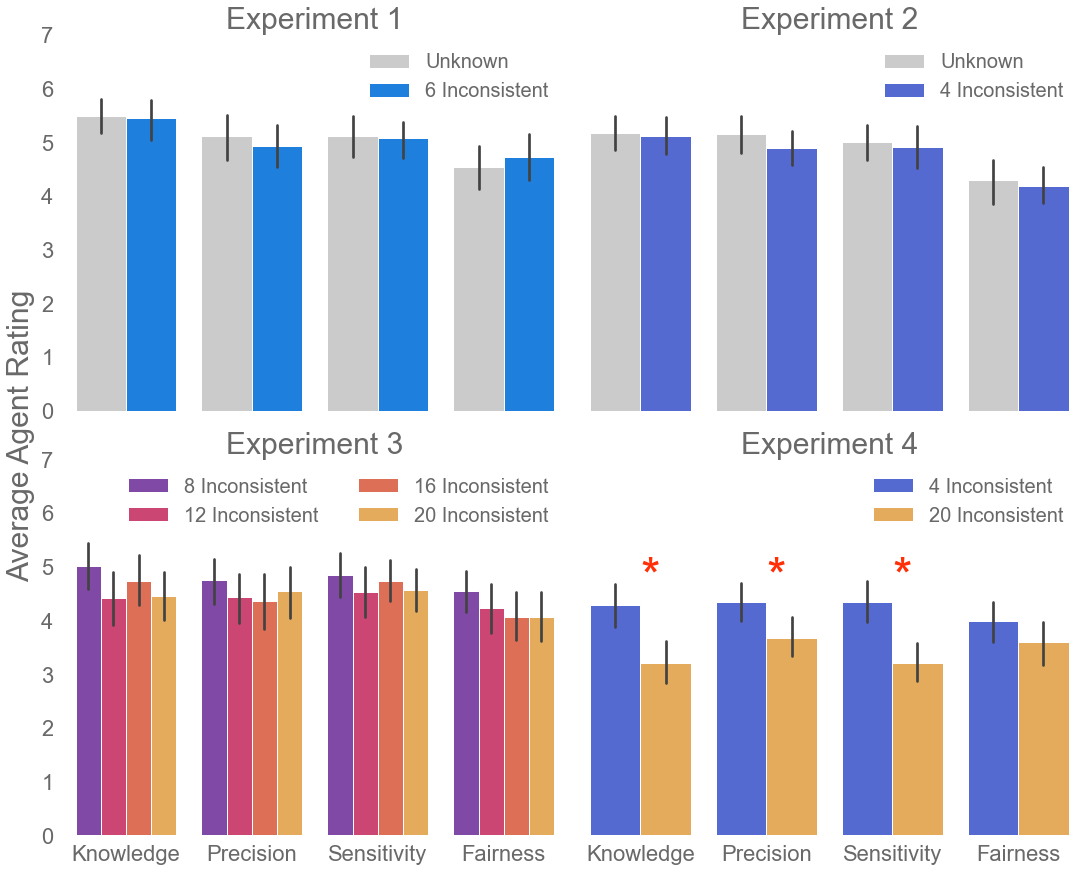

In [10]:
# configure overall figure
fig, axes = plt.subplots(
    2, 2, constrained_layout=True, figsize=(15, 12), sharex=True, sharey=True
)

# plot experiment 1
sns.barplot(
    x="feature",
    y="rating",
    hue="condition",
    palette=["#CBCBCB", "#0080FB"],
    data=select_rating_data(ind_6aliens, 1),
    ax=axes[0, 0],
)
axes[0, 0].set_title("Experiment 1", fontsize=30)
h, l = axes[0, 0].get_legend_handles_labels()
axes[0, 0].legend(
    h,
    ["Unknown", "6 Inconsistent"],
    loc="upper right",
    frameon=False,
    fontsize=20,
)

# plot experiment 2
sns.barplot(
    x="feature",
    y="rating",
    hue="condition",
    palette=["#CBCBCB", "#405DE6"],
    data=select_rating_data(ind_20aliens, 2),
    ax=axes[0, 1],
)
axes[0, 1].set_title("Experiment 2", fontsize=30)
h, l = axes[0, 1].get_legend_handles_labels()
axes[0, 1].legend(
    h,
    ["Unknown", "4 Inconsistent"],
    loc="upper right",
    frameon=False,
    fontsize=20,
)

# plot experiment 3
sns.barplot(
    x="feature",
    y="rating",
    hue="condition",
    palette=["#833AB4", "#E1306C", "#F56040", "#FCAF45"],
    data=select_rating_data(ind_20aliens, 3),
    ax=axes[1, 0],
)
axes[1, 0].set_title("Experiment 3", fontsize=30)
h, l = axes[1, 0].get_legend_handles_labels()
axes[1, 0].legend(
    h,
    ["8 Inconsistent", "12 Inconsistent", "16 Inconsistent", "20 Inconsistent"],
    ncol=2,
    loc="upper right",
    frameon=False,
    fontsize=20,
)

# plot experiment 4
sns.barplot(
    x="feature",
    y="rating",
    hue="condition",
    palette=["#405DE6", "#FCAF45"],
    data=select_rating_data(ind_20aliens, 4),
    ax=axes[1, 1],
)
axes[1, 1].set_title("Experiment 4", fontsize=30)
h, l = axes[1, 1].get_legend_handles_labels()
axes[1, 1].legend(
    h,
    ["4 Inconsistent", "20 Inconsistent"],
    loc="upper right",
    frameon=False,
    fontsize=20,
)
axes[1, 1].text(0, 4.5, r"*", fontsize=50, color="#FF3008")
axes[1, 1].text(1, 4.5, r"*", fontsize=50, color="#FF3008")
axes[1, 1].text(2, 4.5, r"*", fontsize=50, color="#FF3008")

# remove extra labels and legends
for ax in axes.flat:
    ax.label_outer()
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels(["Knowledge", "Precision", "Sensitivity", "Fairness"])
    ax.tick_params(axis="both", which="major", labelsize=22)
    ax.set_ylim(0, 7)

# add shared y-axis label
fig.supylabel("Average Agent Rating", fontsize=30)
sns.despine(left=True, bottom=True)
plt.savefig("agent_ratings_grid.png", dpi=300, bbox_inches="tight")

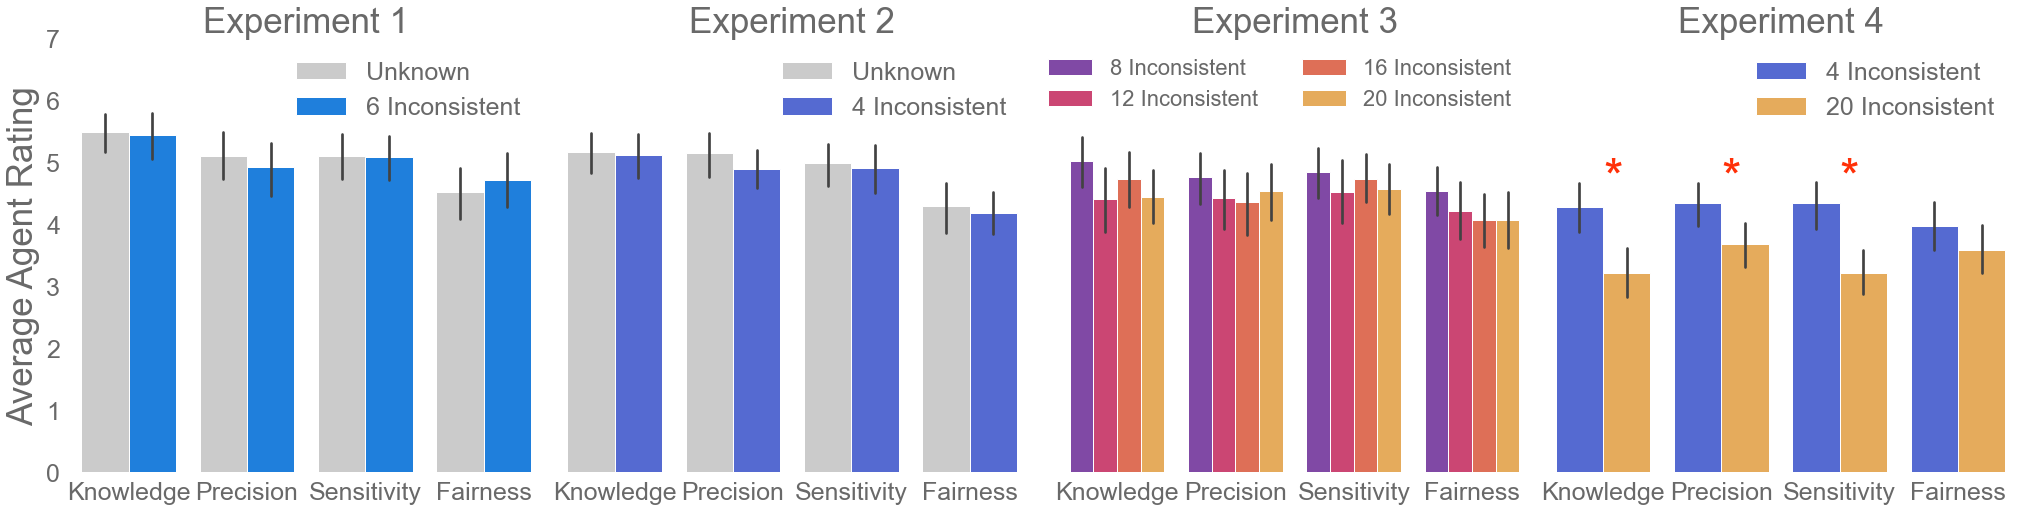

In [11]:
# configure overall figure
fig, axes = plt.subplots(
    1, 4, constrained_layout=True, figsize=(28, 7), sharex=True, sharey=True
)

# plot experiment 1
sns.barplot(
    x="feature",
    y="rating",
    hue="condition",
    palette=["#CBCBCB", "#0080FB"],
    data=select_rating_data(ind_6aliens, 1),
    ax=axes[0],
)
axes[0].set_title("Experiment 1", fontsize=35)
h, l = axes[0].get_legend_handles_labels()
axes[0].legend(
    h,
    ["Unknown", "6 Inconsistent"],
    loc="upper right",
    frameon=False,
    fontsize=25,
)

# plot experiment 2
sns.barplot(
    x="feature",
    y="rating",
    hue="condition",
    palette=["#CBCBCB", "#405DE6"],
    data=select_rating_data(ind_20aliens, 2),
    ax=axes[1],
)
axes[1].set_title("Experiment 2", fontsize=35)
h, l = axes[1].get_legend_handles_labels()
axes[1].legend(
    h,
    ["Unknown", "4 Inconsistent"],
    loc="upper right",
    frameon=False,
    fontsize=25,
)

# plot experiment 3
sns.barplot(
    x="feature",
    y="rating",
    hue="condition",
    palette=["#833AB4", "#E1306C", "#F56040", "#FCAF45"],
    data=select_rating_data(ind_20aliens, 3),
    ax=axes[2],
)
axes[2].set_title("Experiment 3", fontsize=35)
h, l = axes[2].get_legend_handles_labels()
axes[2].legend(
    h,
    ["8 Inconsistent", "12 Inconsistent", "16 Inconsistent", "20 Inconsistent"],
    ncol=2,
    loc="upper right",
    frameon=False,
    fontsize=22,
)

# plot experiment 4
sns.barplot(
    x="feature",
    y="rating",
    hue="condition",
    palette=["#405DE6", "#FCAF45"],
    data=select_rating_data(ind_20aliens, 4),
    ax=axes[3],
)
axes[3].set_title("Experiment 4", fontsize=35)
h, l = axes[3].get_legend_handles_labels()
axes[3].legend(
    h,
    ["4 Inconsistent", "20 Inconsistent"],
    loc="upper right",
    frameon=False,
    fontsize=25,
)
axes[3].text(0, 4.5, r"*", fontsize=50, color="#FF3008")
axes[3].text(1, 4.5, r"*", fontsize=50, color="#FF3008")
axes[3].text(2, 4.5, r"*", fontsize=50, color="#FF3008")

# remove extra labels and legends
for ax in axes.flat:
    ax.label_outer()
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_ylim(0, 7)
    ax.set_xticklabels(["Knowledge", "Precision", "Sensitivity", "Fairness"])
    ax.tick_params(axis="both", which="major", labelsize=25)

# add shared y-axis label
fig.supylabel("Average Agent Rating", fontsize=35)
sns.despine(left=True, bottom=True)
plt.savefig("agent_ratings_horizontal.png", dpi=300, bbox_inches="tight")

## pairwise t-tests

In [12]:
def compare_ratings(metric, decimals):
    """compare given ratings between conditions in all experiments"""

    # print out the metric under comparison
    print(f"---compare {metric} ratings between conditions--- \n")

    # loop through experiments
    for exp in range(1, 5):
        # get results in experiment 1
        if exp == 1:
            results = pg.pairwise_ttests(
                dv=metric,
                between="condition",
                data=ind_6aliens,
                effsize="cohen",
                return_desc=True,
                padjust="bonf",
            ).round(decimals)
        # get results in experiments 2-4
        else:
            results = pg.pairwise_ttests(
                dv=metric,
                between="condition",
                data=ind_20aliens[ind_20aliens["experiment"] == exp],
                effsize="cohen",
                return_desc=True,
                padjust="bonf",
            ).round(decimals)

        # print result of each comparison
        print(f"exp{exp}:\n")
        for index, row in results.iterrows():
            print(
                f"""👉 {row['A']} ({row['mean(A)']}±{row['std(A)']}) vs. {row['B']} ({row['mean(B)']}±{row['std(B)']}): 
                    t({row['dof']})={row['T']}, p={row['p-unc']}, d = {row['cohen']}\n"""
            )

### knowledge

In [13]:
compare_ratings("knowledge", 5)

---compare knowledge ratings between conditions--- 

exp1:

👉 6_counter (5.44681±1.33202) vs. unknown (5.48889±1.10005): 
                    t(88.12639)=-0.16551, p=0.86892, d = -0.03438

exp2:

👉 4_counter (5.12308±1.48437) vs. unknown (5.16981±1.22059): 
                    t(115.98802)=-0.18768, p=0.85146, d = -0.03405

exp3:

👉 12_counter (4.40909±1.71611) vs. 16_counter (4.7381±1.51512): 
                    t(83.50269)=-0.94353, p=0.34813, d = -0.20295

👉 12_counter (4.40909±1.71611) vs. 20_counter (4.45238±1.50126): 
                    t(83.37953)=-0.12466, p=0.90109, d = -0.02681

👉 12_counter (4.40909±1.71611) vs. 8_counter (5.02174±1.46802): 
                    t(84.63864)=-1.81625, p=0.07287, d = -0.38433

👉 16_counter (4.7381±1.51512) vs. 20_counter (4.45238±1.50126): 
                    t(82.0)=0.86812, p=0.38786, d = 0.18944

👉 16_counter (4.7381±1.51512) vs. 8_counter (5.02174±1.46802): 
                    t(84.70675)=-0.89028, p=0.37584, d = -0.19028

👉 20_counter 

### precision

In [14]:
compare_ratings("precision", 5)

---compare precision ratings between conditions--- 

exp1:

👉 6_counter (4.93617±1.4507) vs. unknown (5.11111±1.38535): 
                    t(89.99959)=-0.59166, p=0.55556, d = -0.12327

exp2:

👉 4_counter (4.89231±1.34772) vs. unknown (5.15094±1.30673): 
                    t(112.5365)=-1.05446, p=0.29393, d = -0.19454

exp3:

👉 12_counter (4.43182±1.66213) vs. 16_counter (4.35714±1.70825): 
                    t(83.5374)=0.20533, p=0.83781, d = 0.04432

👉 12_counter (4.43182±1.66213) vs. 20_counter (4.54762±1.51742): 
                    t(83.8382)=-0.33767, p=0.73646, d = -0.07269

👉 12_counter (4.43182±1.66213) vs. 8_counter (4.76087±1.47851): 
                    t(85.77206)=-0.99073, p=0.3246, d = -0.20946

👉 16_counter (4.35714±1.70825) vs. 20_counter (4.54762±1.51742): 
                    t(82.0)=-0.54026, p=0.59048, d = -0.11789

👉 16_counter (4.35714±1.70825) vs. 8_counter (4.76087±1.47851): 
                    t(81.51969)=-1.1803, p=0.24131, d = -0.25357

👉 20_counter (4.

### recall

In [15]:
compare_ratings("recall", 5)

---compare recall ratings between conditions--- 

exp1:

👉 6_counter (5.08511±1.23058) vs. unknown (5.11111±1.28315): 
                    t(89.34342)=-0.09914, p=0.92125, d = -0.0207

exp2:

👉 4_counter (4.90769±1.62714) vs. unknown (5.0±1.1767): 
                    t(114.46873)=-0.357, p=0.72175, d = -0.06398

exp3:

👉 12_counter (4.52273±1.70483) vs. 16_counter (4.7381±1.32627): 
                    t(80.76245)=-0.65554, p=0.51399, d = -0.1406

👉 12_counter (4.52273±1.70483) vs. 20_counter (4.57143±1.30931): 
                    t(80.37354)=-0.14897, p=0.88195, d = -0.03194

👉 12_counter (4.52273±1.70483) vs. 8_counter (4.84783±1.42933): 
                    t(83.98308)=-0.97813, p=0.33082, d = -0.20707

👉 16_counter (4.7381±1.32627) vs. 20_counter (4.57143±1.30931): 
                    t(82.0)=0.57957, p=0.5638, d = 0.12647

👉 16_counter (4.7381±1.32627) vs. 8_counter (4.84783±1.42933): 
                    t(85.9746)=-0.37354, p=0.70967, d = -0.07945

👉 20_counter (4.57143±1.309

### fairness

In [16]:
compare_ratings("fairness", 5)

---compare fairness ratings between conditions--- 

exp1:

👉 6_counter (4.7234±1.48474) vs. unknown (4.53333±1.40777): 
                    t(89.99229)=0.63028, p=0.53011, d = 0.1313

exp2:

👉 4_counter (4.18462±1.39073) vs. unknown (4.30189±1.51385): 
                    t(107.01676)=-0.43405, p=0.66512, d = -0.08103

exp3:

👉 12_counter (4.22727±1.56805) vs. 16_counter (4.07143±1.47157): 
                    t(83.97736)=0.47545, p=0.6357, d = 0.10241

👉 12_counter (4.22727±1.56805) vs. 20_counter (4.07143±1.50435): 
                    t(83.99736)=0.47039, p=0.63929, d = 0.10138

👉 12_counter (4.22727±1.56805) vs. 8_counter (4.54348±1.34506): 
                    t(84.72475)=-1.02477, p=0.30839, d = -0.21683

👉 16_counter (4.07143±1.47157) vs. 20_counter (4.07143±1.50435): 
                    t(82.0)=0.0, p=1.0, d = 0.0

👉 16_counter (4.07143±1.47157) vs. 8_counter (4.54348±1.34506): 
                    t(83.26425)=-1.56578, p=0.12119, d = -0.33555

👉 20_counter (4.07143±1.50435) v

# hit rate inferences

## join human + model predictions

For each person's prediction in each trial, get the corresponding model predictions.

In [17]:
# 6 aliens
df_6aliens = trial_6aliens.merge(
    preds_6aliens[["experiment", "condition", "content", "CRO", "HRO", "CHR"]],
    on=["experiment", "condition", "content"],
)

In [18]:
# 20 aliens
df_20aliens = trial_20aliens.merge(
    preds_20aliens[["experiment", "condition", "content", "CRO", "HRO", "CHR"]],
    on=["experiment", "condition", "content"],
)

## copy agent (experiments 1-2)

In [19]:
# select data only in "Outcomes Unknown"
unknown_6aliens = df_6aliens[df_6aliens["condition"] == "unknown"]
unknown_20aliens = df_20aliens[df_20aliens["condition"] == "unknown"]

### predict `scan` from `n_check`

In [53]:
# how number of aliens Alex checked influenced participants decisions
model_6aliens = Lmer(
    "scan ~ n_check + (1|id) + (1|content)", data=unknown_6aliens, family="binomial"
)
model_6aliens.fit()

Formula: scan~n_check+(1|id)+(1|content)

Family: binomial	 Inference: parametric

Number of observations: 720	 Groups: {'id': 45.0, 'content': 16.0}

Log-likelihood: -316.801 	 AIC: 641.603

Random effects:

                Name    Var    Std
id       (Intercept)  0.542  0.736
content  (Intercept)  0.151  0.389

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-2.302,-3.027,-1.577,0.37,0.100,0.048,0.207,0.091,0.046,0.171,-6.223,0.0,***
n_check,0.882,0.705,1.059,0.09,2.416,2.024,2.884,0.707,0.669,0.743,9.768,0.0,***


In [54]:
# how number of aliens Alex checked influenced participants decisions
model_20aliens = Lmer(
    "scan ~ n_check + (1|id) + (1|content)", data=unknown_20aliens, family="binomial"
)
model_20aliens.fit()

Formula: scan~n_check+(1|id)+(1|content)

Family: binomial	 Inference: parametric

Number of observations: 1272	 Groups: {'id': 53.0, 'content': 24.0}

Log-likelihood: -560.971 	 AIC: 1129.941

Random effects:

                Name    Var    Std
id       (Intercept)  0.509  0.713
content  (Intercept)  0.409  0.640

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-2.326,-3.045,-1.607,0.367,0.098,0.048,0.201,0.089,0.045,0.167,-6.339,0.0,***
n_check,0.268,0.215,0.320,0.027,1.307,1.240,1.377,0.567,0.554,0.579,9.978,0.0,***


### plot `scan` against `n_check`

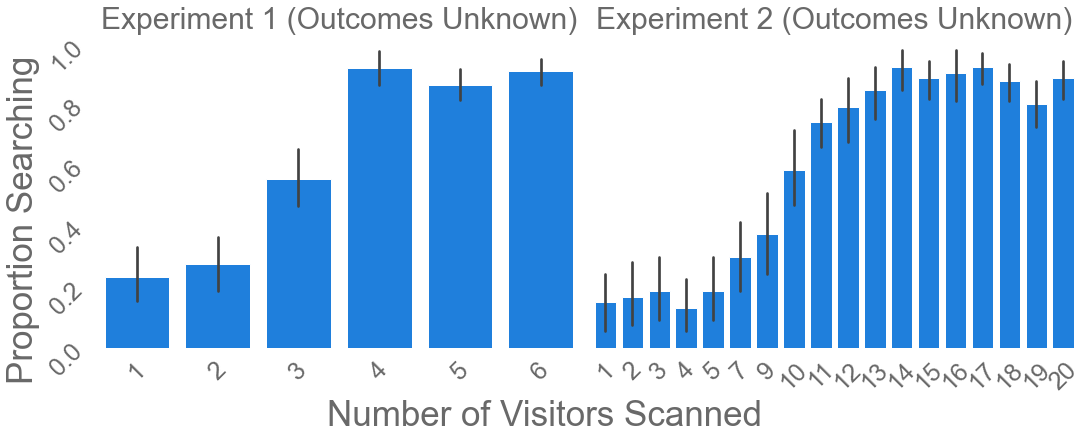

In [22]:
# configure overall figure
fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(15, 6), sharey=True)

# plot experiment 1
sns.barplot(
    x="n_check",
    y="scan",
    data=unknown_6aliens,
    color="#0080FB",
    # err_style="bars",
    # ci=96,
    # lw=5,
    ax=axes[0],
)
axes[0].set_title("Experiment 1 (Outcomes Unknown)", fontsize=30)

# plot experiment 2
sns.barplot(
    x="n_check",
    y="scan",
    data=unknown_20aliens,
    color="#0080FB",
    ax=axes[1],
)
axes[1].set_title("Experiment 2 (Outcomes Unknown)", fontsize=30)

# remove extra labels and legends
for ax in axes.flat:
    ax.label_outer()
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis="both", which="major", labelsize=25, rotation=45)

# add shared y-axis label
fig.supxlabel("Number of Visitors Scanned", fontsize=35)
fig.supylabel("Proportion Searching", fontsize=35)
sns.despine(left=True, bottom=True)
plt.savefig("follow_agent.png", dpi=300, bbox_inches="tight")

## one model in "Outcomes Unknown" (experiments 1-2)

In [23]:
# human + model inferences in 6 aliens (Outcomes Unknown)
unknown_6aliens_infer = pd.melt(
    unknown_6aliens[["id", "n_check", "human_hit", "CRO"]],
    id_vars=["id", "n_check"],
    var_name="source",
    value_name="infer_hit",
)

In [24]:
# human + model inferences in 20 aliens (Outcomes Unknown)
unknown_20aliens_infer = pd.melt(
    unknown_20aliens[["id", "n_check", "human_hit", "CRO"]],
    id_vars=["id", "n_check"],
    var_name="source",
    value_name="infer_hit",
)

In [25]:
# colors to indicate sources
# colors = ["#36C5F0", "#2EB67D", "#E01E5A", "#ECB22E"] # Slack
colors = ["#FF7262", "#A259FF", "#1ABCFE", "#0ACF83"]  # Figma
sources = ["Human Inference", "Search Rate Only", "Hit Rate Only", "Search + Hit Rates"]

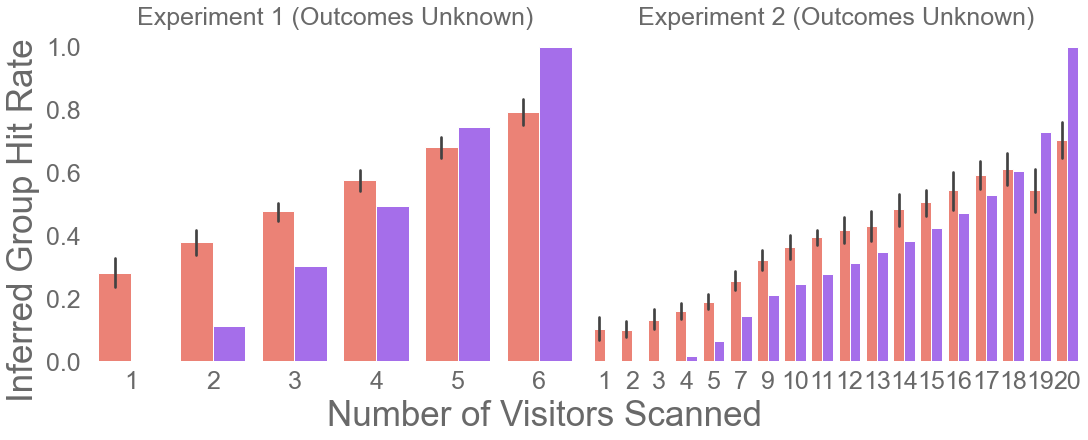

In [26]:
# configure overall figure
fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(15, 6), sharey=True)

# plot experiment 1
sns.barplot(
    x="n_check",
    y="infer_hit",
    hue="source",
    data=unknown_6aliens_infer,
    palette=colors[:2],
    ax=axes[0],
)
axes[0].set_title("Experiment 1 (Outcomes Unknown)", fontsize=25)

# plot experiment 2
sns.barplot(
    x="n_check",
    y="infer_hit",
    hue="source",
    palette=colors[:2],
    data=unknown_20aliens_infer,
    ax=axes[1],
)
axes[1].set_title("Experiment 2 (Outcomes Unknown)", fontsize=25)

# remove extra labels and legends
for ax in axes.flat:
    ax.label_outer()
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis="both", which="major", labelsize=25)
    ax.get_legend().remove()
    # h, l = ax.get_legend_handles_labels()
    # ax.legend(
    #     h,
    #     sources[:2],
    #     loc="upper left",
    #     frameon=False,
    #     fontsize=20,
    # )

# add shared y-axis label
fig.supxlabel("Number of Visitors Scanned", fontsize=35)
fig.supylabel("Inferred Group Hit Rate", fontsize=35)
sns.despine(left=True, bottom=True)
plt.savefig("unknown_model_vs_people.png", dpi=300, bbox_inches="tight")

## 3 models in "Outcomes Revealed" (experiments 1-4)

### select critical trials

In [27]:
# content of critical trials
crt_6aliens = [
    "1 out of 1",
    "2 out of 2",
    "1 out of 5",
    "1 out of 6",
    "0 out of 5",
    "0 out of 6",
]

crt_20aliens = [
    "3 out of 3",
    "4 out of 4",
    "0 out of 19",
    "2 out of 20",
]

In [28]:
# get data in critical trials
known_6aliens = df_6aliens[
    (df_6aliens["condition"] != "unknown") & df_6aliens["content"].isin(crt_6aliens)
]

known_20aliens = df_20aliens[
    (df_20aliens["condition"] != "unknown") & df_20aliens["content"].isin(crt_20aliens)
]

In [29]:
# human + model inferences in 6 aliens (Outcomes Revealed)
known_6aliens_infer = pd.melt(
    known_6aliens[["id", "content", "human_hit", "CRO", "HRO", "CHR"]],
    id_vars=["id", "content"],
    var_name="source",
    value_name="infer_hit",
)

In [30]:
# human + model inferences in 20 aliens (Outcomes Revealed)
known_20aliens_infer = pd.melt(
    known_20aliens[["id", "content", "human_hit", "CRO", "HRO", "CHR"]],
    id_vars=["id", "content"],
    var_name="source",
    value_name="infer_hit",
)
# add experiment number
known_20aliens_infer["experiment"] = known_20aliens_infer["id"].apply(
    lambda x: int(re.findall(r"(exp)(\d)(_)", x)[0][1])
)
# add condition
known_20aliens_infer["condition"] = known_20aliens_infer["id"].apply(
    lambda x: re.findall(r"(_)(.+)(_)", x)[0][1]
)
known_20aliens_infer["condition"].replace(
    {
        "20to4": "4 Inconsistent",
        "16to8": "8 Inconsistent",
        "12to12": "12 Inconsistent",
        "8to16": "16 Inconsistent",
        "4to20": "20 Inconsistent",
    },
    inplace=True,
)

### plot model vs. human inferences

Experiments 1-2 only have one condition where outcomes were revealed.

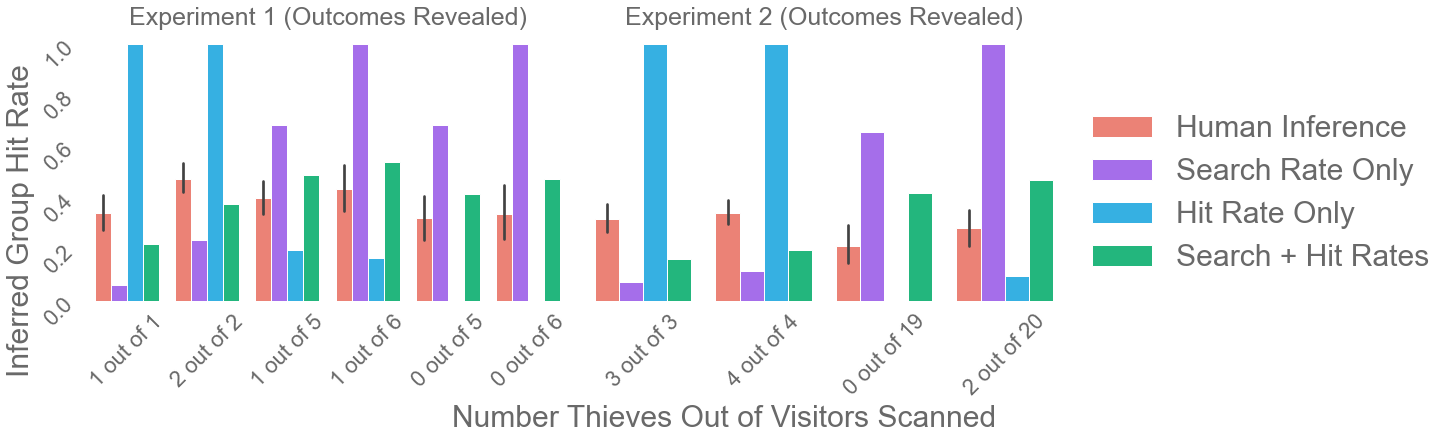

In [31]:
# configure overall figure
fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(20, 6), sharey=True)

# plot experiment 1
sns.barplot(
    x="content",
    y="infer_hit",
    hue="source",
    data=known_6aliens_infer,
    palette=colors,
    order=crt_6aliens,
    ax=axes[0],
)
axes[0].set_title("Experiment 1 (Outcomes Revealed)", fontsize=25)
axes[0].get_legend().remove()

# plot experiment 2
sns.barplot(
    x="content",
    y="infer_hit",
    hue="source",
    data=known_20aliens_infer[known_20aliens_infer["experiment"] == 2],
    palette=colors,
    order=crt_20aliens,
    ax=axes[1],
)
axes[1].set_title("Experiment 2 (Outcomes Revealed)", fontsize=25)
h, l = axes[1].get_legend_handles_labels()
axes[1].legend(
    h,
    sources,
    loc="center left",
    bbox_to_anchor=(1, 0.4),
    frameon=False,
    fontsize=30,
)

# remove extra labels and legends
for ax in axes.flat:
    ax.label_outer()
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis="both", which="major", labelsize=22, rotation=45)

# add shared y-axis label
fig.supxlabel("Number Thieves Out of Visitors Scanned", fontsize=30)
fig.supylabel("Inferred Group Hit Rate", fontsize=30)
sns.despine(left=True, bottom=True)
plt.savefig("revealed_model_vs_people_exp1-2.png", dpi=300, bbox_inches="tight")

Experiment 3 alone has 4 conditions where outcomes were revealed.

In [32]:
# isolate Experiment 3 data
exp3_infer = known_20aliens_infer[known_20aliens_infer["experiment"] == 3]

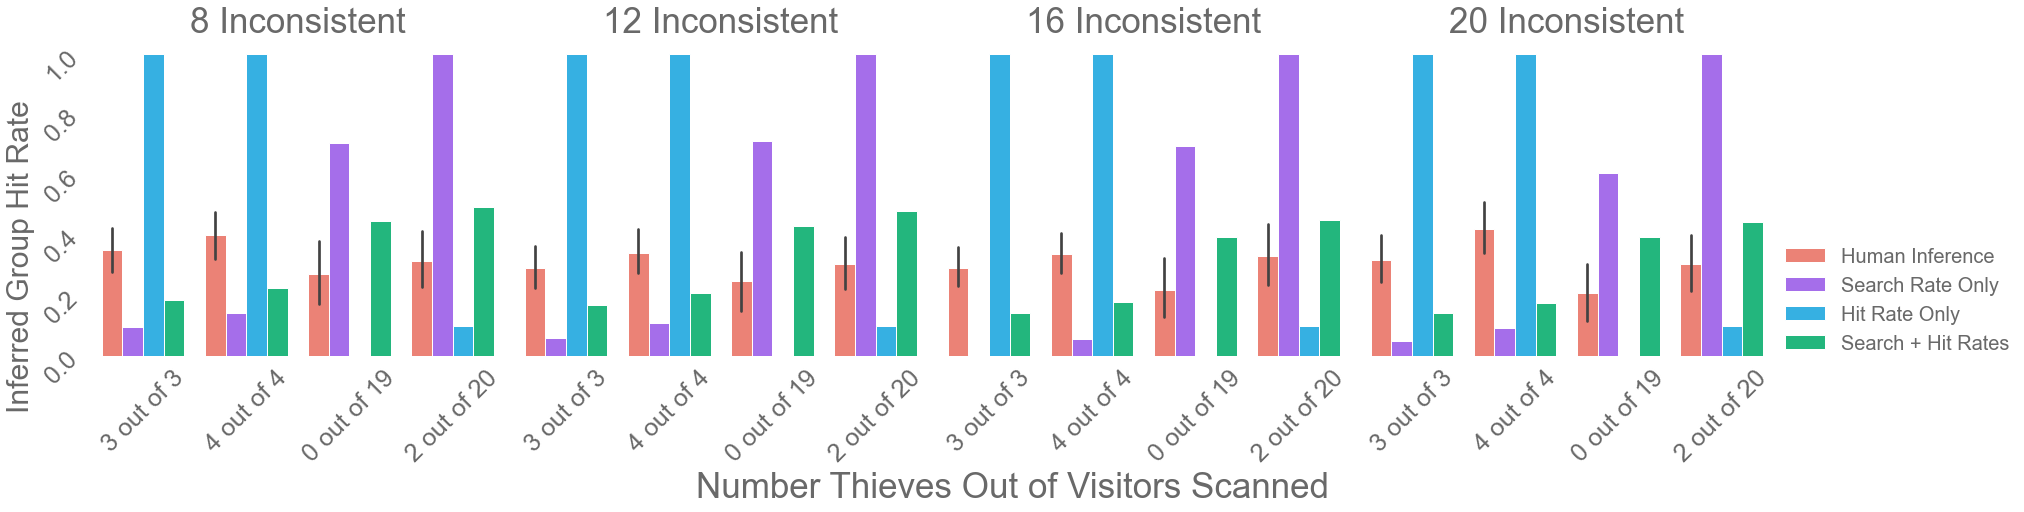

In [33]:
# configure overall figure
fig, axes = plt.subplots(
    1, 4, constrained_layout=True, figsize=(28, 7), sharex=True, sharey=True
)

# plot each condition in experiment 3
for i, condition in enumerate(exp3_infer["condition"].unique()):
    sns.barplot(
        x="content",
        y="infer_hit",
        hue="source",
        data=exp3_infer[exp3_infer["condition"] == condition],
        palette=colors,
        order=crt_20aliens,
        ax=axes[i],
    )
    axes[i].set_title(f"{condition}", fontsize=35)
    if i < 3:
        axes[i].get_legend().remove()
    else:
        h, l = axes[i].get_legend_handles_labels()
        axes[i].legend(
            h,
            sources,
            loc="upper center",
            bbox_to_anchor=(1.3, 0.4),
            frameon=False,
            fontsize=20,
        )

# remove extra labels and legends
for ax in axes.flat:
    ax.label_outer()
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis="both", which="major", labelsize=25, rotation=45)

# add shared y-axis label
fig.supxlabel("Number Thieves Out of Visitors Scanned", fontsize=35)
fig.supylabel("Inferred Group Hit Rate", fontsize=30)
sns.despine(left=True, bottom=True)
plt.savefig(
    "revealed_model_vs_people_exp3_horizontal.png", dpi=300, bbox_inches="tight"
)

Create a 2 $\times$ 2 grid version.

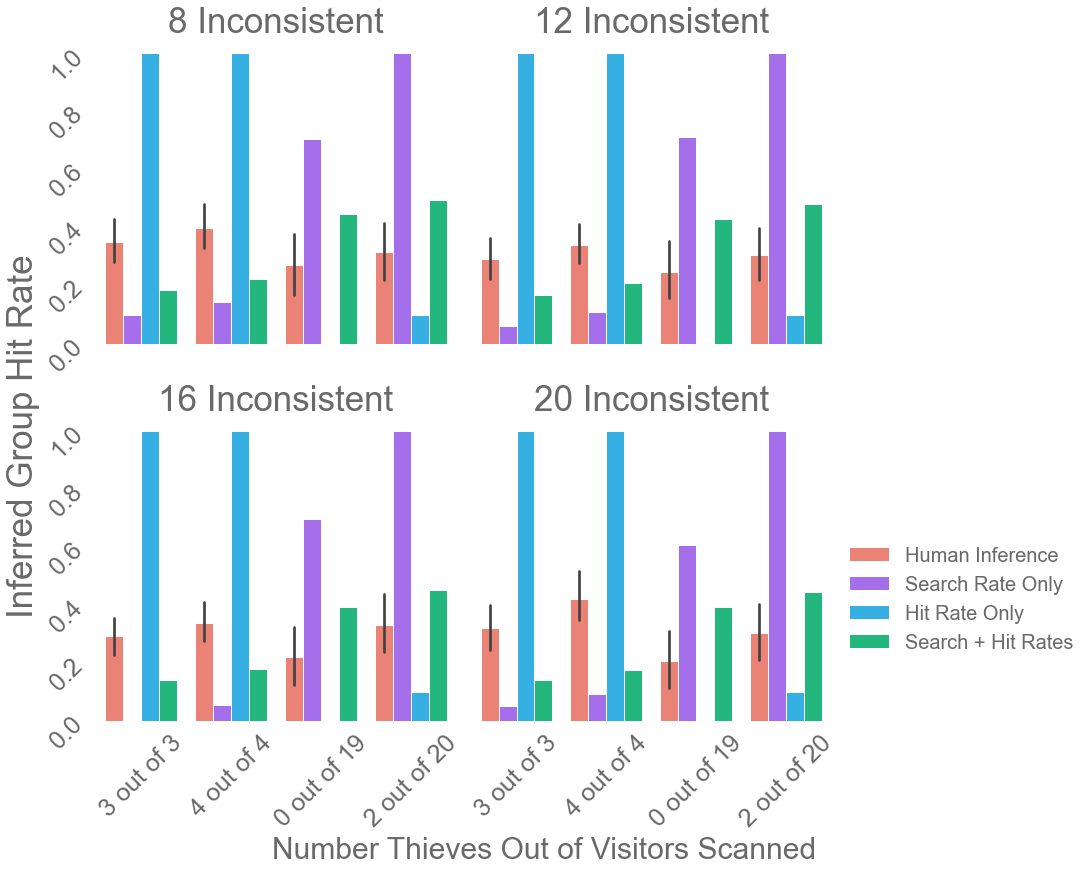

In [34]:
# configure overall figure
fig, axes = plt.subplots(
    2, 2, constrained_layout=True, figsize=(15, 12), sharex=True, sharey=True
)

# plot each condition in experiment 3
for i, condition in enumerate(exp3_infer["condition"].unique()):
    sns.barplot(
        x="content",
        y="infer_hit",
        hue="source",
        data=exp3_infer[exp3_infer["condition"] == condition],
        palette=colors,
        order=crt_20aliens,
        ax=axes[i // 2, i % 2],
    )
    axes[i // 2, i % 2].set_title(f"{condition}", fontsize=35)
    if i < 3:
        axes[i // 2, i % 2].get_legend().remove()
    else:
        h, l = axes[i // 2, i % 2].get_legend_handles_labels()
        axes[i // 2, i % 2].legend(
            h,
            sources,
            loc="center left",
            bbox_to_anchor=(1, 0.4),
            frameon=False,
            fontsize=20,
        )

# remove extra labels and legends
for ax in axes.flat:
    ax.label_outer()
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis="both", which="major", labelsize=25, rotation=45)

# add shared y-axis label
fig.supxlabel("Number Thieves Out of Visitors Scanned", fontsize=30)
fig.supylabel("Inferred Group Hit Rate", fontsize=35)
sns.despine(left=True, bottom=True)
plt.savefig("revealed_model_vs_people_exp3_grid.png", dpi=300, bbox_inches="tight")

Experiment 4 also has 2 conditions where outcomes were revealed.

In [35]:
# isolate Experiment 4 data
exp4_infer = known_20aliens_infer[known_20aliens_infer["experiment"] == 4]

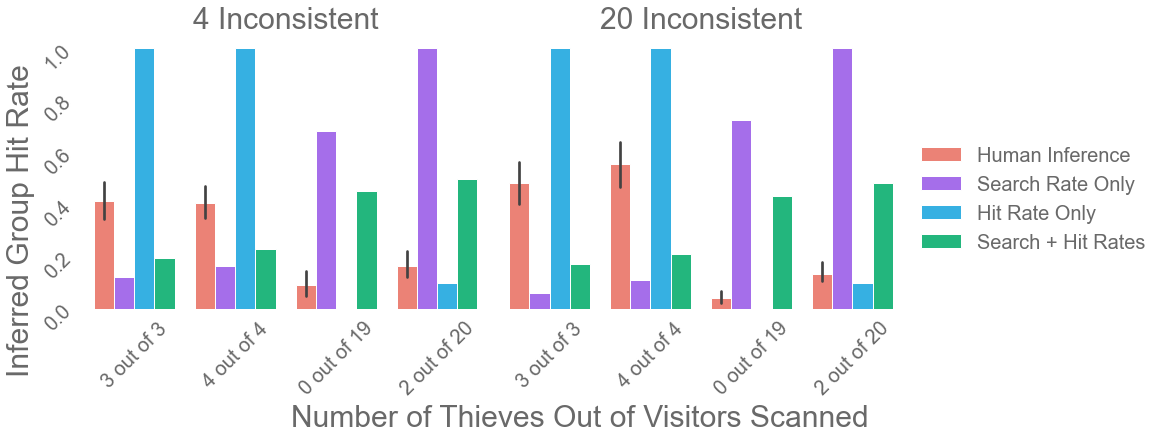

In [36]:
# configure overall figure
fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(16, 6), sharey=True)

# plot each condition in experiment 4
for i, condition in enumerate(exp4_infer["condition"].unique()):
    sns.barplot(
        x="content",
        y="infer_hit",
        hue="source",
        data=exp4_infer[exp4_infer["condition"] == condition],
        palette=colors,
        order=crt_20aliens,
        ax=axes[i],
    )
    axes[i].set_title(f"{condition}", fontsize=30)
    if i == 0:
        axes[i].get_legend().remove()
    else:
        h, l = axes[i].get_legend_handles_labels()
        axes[i].legend(
            h,
            sources,
            loc="center left",
            bbox_to_anchor=(1, 0.4),
            frameon=False,
            fontsize=20,
        )

# remove extra labels and legends
for ax in axes.flat:
    ax.label_outer()
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis="both", which="major", labelsize=20, rotation=45)

# add shared y-axis label
fig.supxlabel("Number of Thieves Out of Visitors Scanned", fontsize=30)
fig.supylabel("Inferred Group Hit Rate", fontsize=30)
sns.despine(left=True, bottom=True)
plt.savefig("revealed_model_vs_people_exp4.png", dpi=300, bbox_inches="tight")

### model comparisons

In [37]:
def compare_models(n_aliens, critical_only):
    """compare 3 models with human inferences"""

    # select data to use
    if n_aliens == 6 and critical_only:
        df = df_6aliens[df_6aliens["content"].isin(crt_6aliens)]
    elif n_aliens == 20 and critical_only:
        df = df_20aliens[df_20aliens["content"].isin(crt_20aliens)]
    elif n_aliens == 6 and not critical_only:
        df = df_6aliens
    else:
        df = df_20aliens

    # don't include "Outcomes Unknown"
    df = df[df["condition"] != "unknown"]

    # which trials are included
    if critical_only:
        print("compare critical trials:\n")
    else:
        print("compare all trials:\n")

    # iterate through all experiments and conditions
    for experiment in sorted(df["experiment"].unique()):
        for condition in df[df["experiment"] == experiment]["condition"].unique():
            # isolate data in given experiment and condition
            df_subset = df[
                (df["experiment"] == experiment) & (df["condition"] == condition)
            ]
            # calculate RMSE between human inferences and model inferences
            rmse_cro = mean_squared_error(
                df_subset["human_hit"], df_subset["CRO"], squared=False
            )
            rmse_hro = mean_squared_error(
                df_subset["human_hit"], df_subset["HRO"], squared=False
            )
            rmse_cho = mean_squared_error(
                df_subset["human_hit"], df_subset["CHR"], squared=False
            )

            # print results
            print(
                f"- RMSE in experiment{experiment} ({condition}): CRO - {round(rmse_cro, 3)}, HRO - {round(rmse_hro, 3)}, CHR - {round(rmse_cho, 3)}"
            )

In [38]:
# experiment 1 comparison (all trials)
compare_models(n_aliens=6, critical_only=False)

compare all trials:

- RMSE in experiment1 (6_counter): CRO - 0.351, HRO - 0.357, CHR - 0.242


In [39]:
# experiment 1 comparison (critical trials)
compare_models(n_aliens=6, critical_only=True)

compare critical trials:

- RMSE in experiment1 (6_counter): CRO - 0.512, HRO - 0.503, CHR - 0.302


In [40]:
# experiments 2-4 comparison (all trials)
compare_models(n_aliens=20, critical_only=False)

compare all trials:

- RMSE in experiment2 (4_counter): CRO - 0.266, HRO - 0.277, CHR - 0.196
- RMSE in experiment3 (8_counter): CRO - 0.357, HRO - 0.339, CHR - 0.24
- RMSE in experiment3 (12_counter): CRO - 0.388, HRO - 0.403, CHR - 0.235
- RMSE in experiment3 (16_counter): CRO - 0.472, HRO - 0.413, CHR - 0.264
- RMSE in experiment3 (20_counter): CRO - 0.513, HRO - 0.44, CHR - 0.312
- RMSE in experiment4 (4_counter): CRO - 0.275, HRO - 0.237, CHR - 0.193
- RMSE in experiment4 (20_counter): CRO - 0.605, HRO - 0.32, CHR - 0.348


In [41]:
# experiments 2-4 comparison (critical trials)
compare_models(n_aliens=20, critical_only=True)

compare critical trials:

- RMSE in experiment2 (4_counter): CRO - 0.52, HRO - 0.556, CHR - 0.311
- RMSE in experiment3 (8_counter): CRO - 0.538, HRO - 0.565, CHR - 0.352
- RMSE in experiment3 (12_counter): CRO - 0.526, HRO - 0.581, CHR - 0.317
- RMSE in experiment3 (16_counter): CRO - 0.533, HRO - 0.58, CHR - 0.314
- RMSE in experiment3 (20_counter): CRO - 0.54, HRO - 0.553, CHR - 0.349
- RMSE in experiment4 (4_counter): CRO - 0.586, HRO - 0.473, CHR - 0.356
- RMSE in experiment4 (20_counter): CRO - 0.666, HRO - 0.406, CHR - 0.412


### strategy weighting

In [42]:
def get_linear_coeffs(n_aliens, models, critical_only):

    # select data to use
    if n_aliens == 6 and critical_only:
        df = df_6aliens[df_6aliens["content"].isin(crt_6aliens)]
    elif n_aliens == 20 and critical_only:
        df = df_20aliens[df_20aliens["content"].isin(crt_20aliens)]
    elif n_aliens == 6 and not critical_only:
        df = df_6aliens
    else:
        df = df_20aliens

    # don't include "Outcomes Unknown"
    df = df[df["condition"] != "unknown"]

    # initialize empty list to collect coefficients
    coeff_list = []
    index_list = []

    # iterate through all experiments and conditions
    for experiment in sorted(df["experiment"].unique()):
        for condition in df[df["experiment"] == experiment]["condition"].unique():
            index_list.append("exp" + str(experiment) + "_" + str(condition))
            # isolate data in given experiment and condition
            df_subset = df[
                (df["experiment"] == experiment) & (df["condition"] == condition)
            ]

            # predictors
            X = df_subset[models]
            y = df_subset["human_hit"]

            # fit regression model and collect coefficients
            lr = LinearRegression().fit(X, y)
            coeff_list.append(lr.coef_)

        # convert list of arrays into a dataframe
        df_coeffs = pd.DataFrame(
            list(map(np.ravel, coeff_list)),
            columns=models,
            index=index_list,
        )

    return df_coeffs

We can use inferred hit rates...

In [43]:
# 6 aliens (critical trials only)
get_linear_coeffs(n_aliens=6, models=["CRO", "HRO"], critical_only=True)

,CRO,HRO
exp1_6_counter,0.242545,0.230003


In [44]:
# 6 aliens (all trials)
get_linear_coeffs(n_aliens=6, models=["CRO", "HRO"], critical_only=False)

,CRO,HRO
exp1_6_counter,0.357897,0.385523


In [45]:
# 20 aliens (critical trials only)
get_linear_coeffs(n_aliens=20, models=["CRO", "HRO"], critical_only=True)

,CRO,HRO
exp2_4_counter,0.146112,0.199501
exp3_8_counter,0.108686,0.168694
exp3_12_counter,0.163847,0.173003
exp3_16_counter,0.286974,0.288228
exp3_20_counter,0.194596,0.269484
exp4_4_counter,0.107578,0.376184
exp4_20_counter,0.156004,0.579117


In [46]:
# 20 aliens (all trials)
get_linear_coeffs(n_aliens=20, models=["CRO", "HRO"], critical_only=False)

,CRO,HRO
exp2_4_counter,0.397401,0.434394
exp3_8_counter,0.375487,0.447322
exp3_12_counter,0.451344,0.434433
exp3_16_counter,0.268728,0.335235
exp3_20_counter,0.176055,0.285223
exp4_4_counter,0.264582,0.529726
exp4_20_counter,0.087248,0.503836


... or observed rates.

In [47]:
# 6 aliens (critical trials only)
get_linear_coeffs(n_aliens=6, models=["check_rate", "hit_rate"], critical_only=True)

,check_rate,hit_rate
exp1_6_counter,0.462798,0.380519


In [48]:
# 6 aliens (all trials)
get_linear_coeffs(n_aliens=6, models=["check_rate", "hit_rate"], critical_only=False)

,check_rate,hit_rate
exp1_6_counter,0.39974,0.383327


In [49]:
# 20 aliens (critical trials only)
get_linear_coeffs(n_aliens=20, models=["check_rate", "hit_rate"], critical_only=True)

,check_rate,hit_rate
exp2_4_counter,0.447244,0.463656
exp3_8_counter,0.348354,0.377941
exp3_12_counter,0.482241,0.446234
exp3_16_counter,0.815452,0.727958
exp3_20_counter,0.794824,0.788333
exp4_4_counter,0.267090,0.522397
exp4_20_counter,0.483935,0.858960


In [50]:
# 20 aliens (all trials)
get_linear_coeffs(n_aliens=20, models=["check_rate", "hit_rate"], critical_only=False)

,check_rate,hit_rate
exp2_4_counter,0.379130,0.409557
exp3_8_counter,0.402118,0.425208
exp3_12_counter,0.534212,0.468493
exp3_16_counter,0.450988,0.455480
exp3_20_counter,0.329621,0.418217
exp4_4_counter,0.259161,0.512349
exp4_20_counter,0.163054,0.565816
